In [1]:
import os
import random
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.io import read_image
import torch.nn as nn




from functools import partial

import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm  # Import tqdm for progress bars

from mae_models import MaskedAutoencoderViT 

/home/alcindo/.pyenv/versions/mae-cows/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Set device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device: ", device)

Using device:  cuda


In [3]:
BATCH_SIZE = 512
IMG_SIZE = (48, 48)  # Resize images to 48x48

In [4]:
# load pytorch cifar10 dataset
from torchvision.datasets import CIFAR10
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
])
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

#val dataset
val_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)




In [5]:
# (self, img_size=224, patch_size=16, in_chans=3,
#                  embed_dim=1024, depth=24, num_heads=16,
#                  decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
#                  mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False)


# Initialize the MAE model with in_channels=1 for grayscale images and send it to device
model = MaskedAutoencoderViT(
        patch_size=6, embed_dim=64, depth=6, num_heads=8, in_chans=3, img_size= (48,48),
        decoder_embed_dim=32, decoder_depth=4, decoder_num_heads=4,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6))


model = model.to(device)
# Define the optimizer (AdamW)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)


In [6]:

# split the images located in the batch into patches images[128, 1, 224, 224]-> (128, 1, num_patches, patch_size, patch_size)

def split_images(images, patch_size):
    # Get the image size
    H, W = images.shape[-2:]
    # Calculate the n6umber of patches in height and width
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    # Split the images into patches
    patches = images.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.contiguous().view(images.size(0), images.size(1), num_patches_h*num_patches_w, patch_size, patch_size)
    return patches

def apply_mask_to_patches(images, patches, masks, patch_size):
    """
    Substitui os patches mascarados por uma matriz de 1s.

    images: tensor original [B, C, H, W]
    patches: tensor de patches [B, C, num_patches, patch_size, patch_size]
    masks: tensor de máscara [B, num_patches] (0 para manter, 1 para mascarar)
    patch_size: tamanho dos patches
    """
    B, C, num_patches, H, W = patches.shape  # [128, 1, 196, 16, 16]

    # Criar tensor de 1s do mesmo tamanho de patches
    masked_patches = patches.clone()
    ones_patch = torch.ones((C, patch_size, patch_size), device=patches.device)

    # Aplicar máscara manualmente usando loops
    for b in range(masks.shape[0]):  # Para cada imagem no batch
        for i in range(masks.shape[1]):  # Para cada patch
            if masks[b, i] == 1:
                masked_patches[b, :, i, :, :] = ones_patch  # Substituir por 1s

    # Reconstruir as imagens mascaradas
    num_patches_per_row = int(images.shape[-1] // patch_size)  # Ex: 224 / 16 = 14 patches por linha
    masked_images = masked_patches.view(B, C, num_patches_per_row, num_patches_per_row, patch_size, patch_size)
    masked_images = masked_images.permute(0, 1, 2, 4, 3, 5).contiguous().view(B, C, images.shape[-2], images.shape[-1])

    return masked_images

def visualize_image(original, masked_image, recon_images):
    """
    Plota imagens originais (RGB), mascaradas e reconstruídas.
    """

    # Seleciona um índice aleatório do batch
    index = random.randint(0, original.shape[0]-1)

    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    # --- Imagem Original ---
    # Pega a imagem [C, H, W] e permuta para [H, W, C] para o matplotlib
    img_orig = original[index].permute(1, 2, 0).cpu().detach().numpy()
    axes[0].imshow(img_orig)
    axes[0].set_title("Original")
    axes[0].axis("off")

    # --- Imagem Mascarada ---
    # Pega a imagem [C, H, W] e permuta para [H, W, C]
    img_masked = masked_image[index].permute(1, 2, 0).cpu().detach().numpy()
    axes[1].imshow(img_masked)
    axes[1].set_title("Masked")
    axes[1].axis("off")

    # --- Imagem Reconstruída ---
    # Pega a imagem [C, H, W] e permuta para [H, W, C]
    img_recon = recon_images[index].permute(1, 2, 0).cpu().detach().numpy()
    axes[2].imshow(img_recon)
    axes[2].set_title("Reconstructed")
    axes[2].axis("off")

    plt.show()

Epoch [1/100] Train Loss: 0.28486314


Epoch [1/100] Validation Loss: 0.15416351


Epoch [2/100] Train Loss: 0.11363327


Epoch [2/100] Validation Loss: 0.08665834


Epoch [3/100] Train Loss: 0.07445544


Epoch [3/100] Validation Loss: 0.06689298


Epoch [4/100] Train Loss: 0.06377353


Epoch [4/100] Validation Loss: 0.06189243


Epoch [5/100] Train Loss: 0.06087282


Epoch [5/100] Validation Loss: 0.06011457


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.84047943..1.810812].


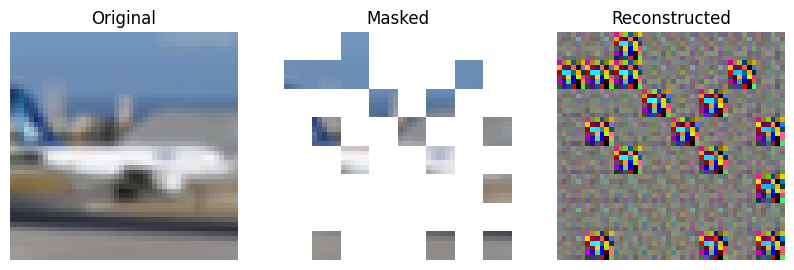

Epoch [6/100] Train Loss: 0.05945661


Epoch [6/100] Validation Loss: 0.05867028


Epoch [7/100] Train Loss: 0.05794466


Epoch [7/100] Validation Loss: 0.05701913


Epoch [8/100] Train Loss: 0.05604508


Epoch [8/100] Validation Loss: 0.05486528


Epoch [9/100] Train Loss: 0.05362955


Epoch [9/100] Validation Loss: 0.05219197


Epoch [10/100] Train Loss: 0.05069679


Epoch [10/100] Validation Loss: 0.04876451


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0372479..2.2232466].


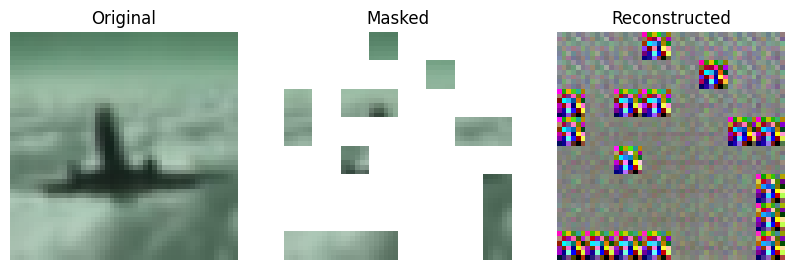

Epoch [11/100] Train Loss: 0.04668581


Epoch [11/100] Validation Loss: 0.04478483


Epoch [12/100] Train Loss: 0.04288095


Epoch [12/100] Validation Loss: 0.04145752


Epoch [13/100] Train Loss: 0.04002653


Epoch [13/100] Validation Loss: 0.03869441


Epoch [14/100] Train Loss: 0.03747217


Epoch [14/100] Validation Loss: 0.03629823


Epoch [15/100] Train Loss: 0.03546078


Epoch [15/100] Validation Loss: 0.03474111


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1535178..2.2401805].


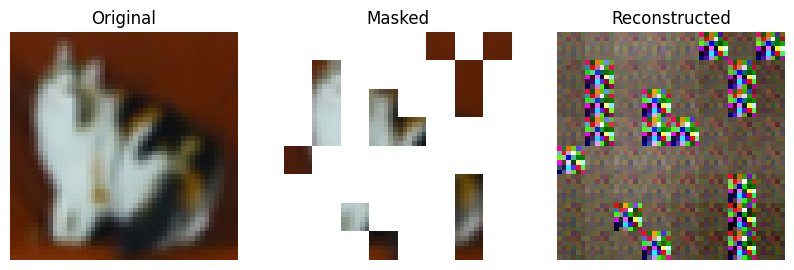

Epoch [16/100] Train Loss: 0.03399994


Epoch [16/100] Validation Loss: 0.03358488


Epoch [17/100] Train Loss: 0.03291852


Epoch [17/100] Validation Loss: 0.03253219


Epoch [18/100] Train Loss: 0.03219777


Epoch [18/100] Validation Loss: 0.03173988


Epoch [19/100] Train Loss: 0.03157998


Epoch [19/100] Validation Loss: 0.03156542


Epoch [20/100] Train Loss: 0.03110017


Epoch [20/100] Validation Loss: 0.03120217


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.416776..2.6586902].


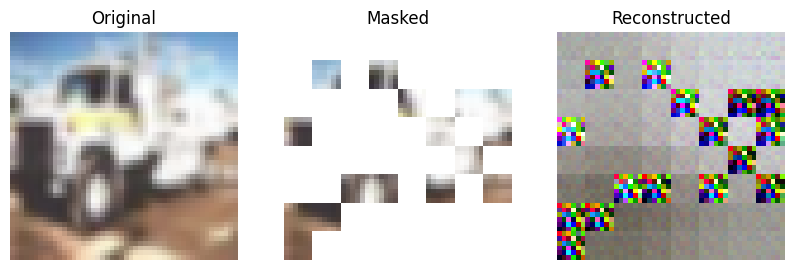

Epoch [21/100] Train Loss: 0.03069288


Epoch [21/100] Validation Loss: 0.03059411


Epoch [22/100] Train Loss: 0.03029793


Epoch [22/100] Validation Loss: 0.03019566


Epoch [23/100] Train Loss: 0.03008334


Epoch [23/100] Validation Loss: 0.02994574


Epoch [24/100] Train Loss: 0.02965645


Epoch [24/100] Validation Loss: 0.02949322


Epoch [25/100] Train Loss: 0.02937220


Epoch [25/100] Validation Loss: 0.02936034


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.468405..2.503088].


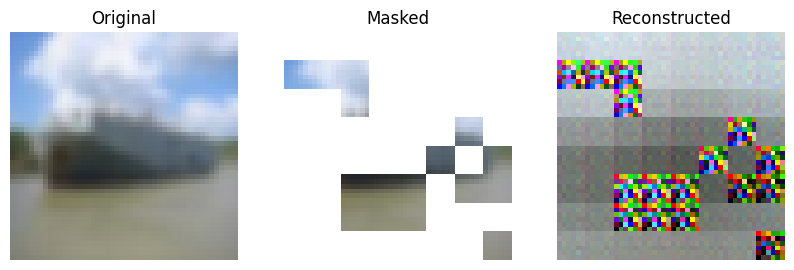

Epoch [26/100] Train Loss: 0.02903933


Epoch [26/100] Validation Loss: 0.02898564


Epoch [27/100] Train Loss: 0.02878244


Epoch [27/100] Validation Loss: 0.02863223


Epoch [28/100] Train Loss: 0.02846158


Epoch [28/100] Validation Loss: 0.02843234


Epoch [29/100] Train Loss: 0.02812798


Epoch [29/100] Validation Loss: 0.02793216


Epoch [30/100] Train Loss: 0.02783417


Epoch [30/100] Validation Loss: 0.02796432


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2898163..2.4350128].


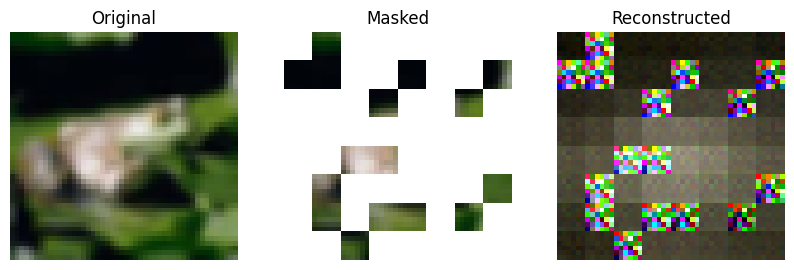

Epoch [31/100] Train Loss: 0.02760758


Epoch [31/100] Validation Loss: 0.02753708


Epoch [32/100] Train Loss: 0.02739732


Epoch [32/100] Validation Loss: 0.02723326


Epoch [33/100] Train Loss: 0.02710865


Epoch [33/100] Validation Loss: 0.02703443


Epoch [34/100] Train Loss: 0.02690720


Epoch [34/100] Validation Loss: 0.02671119


Epoch [35/100] Train Loss: 0.02661685


Epoch [35/100] Validation Loss: 0.02662373


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3004692..2.5690522].


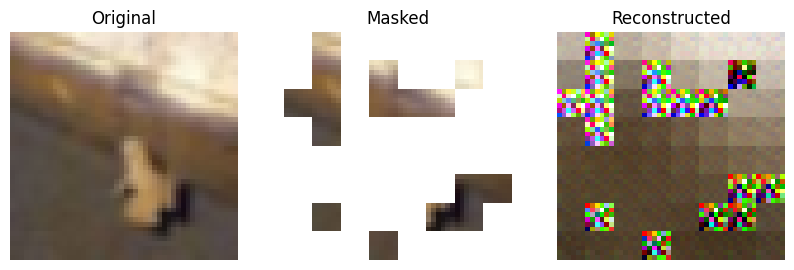

Epoch [36/100] Train Loss: 0.02639866


Epoch [36/100] Validation Loss: 0.02647152


Epoch [37/100] Train Loss: 0.02623688


Epoch [37/100] Validation Loss: 0.02635468


Epoch [38/100] Train Loss: 0.02605690


Epoch [38/100] Validation Loss: 0.02606646


Epoch [39/100] Train Loss: 0.02589592


Epoch [39/100] Validation Loss: 0.02576612


Epoch [40/100] Train Loss: 0.02579478


Epoch [40/100] Validation Loss: 0.02570884


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5367141..2.5834312].


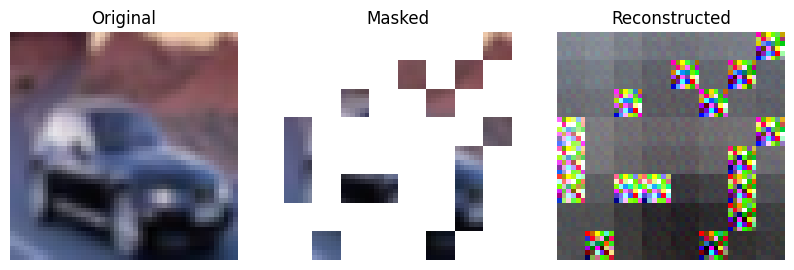

Epoch [41/100] Train Loss: 0.02559135


Epoch [41/100] Validation Loss: 0.02568101


Epoch [42/100] Train Loss: 0.02538456


Epoch [42/100] Validation Loss: 0.02533958


Epoch [43/100] Train Loss: 0.02523835


Epoch [43/100] Validation Loss: 0.02530785


Epoch [44/100] Train Loss: 0.02516453


Epoch [44/100] Validation Loss: 0.02507081


Epoch [45/100] Train Loss: 0.02501645


Epoch [45/100] Validation Loss: 0.02495315


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7420006..2.5775015].


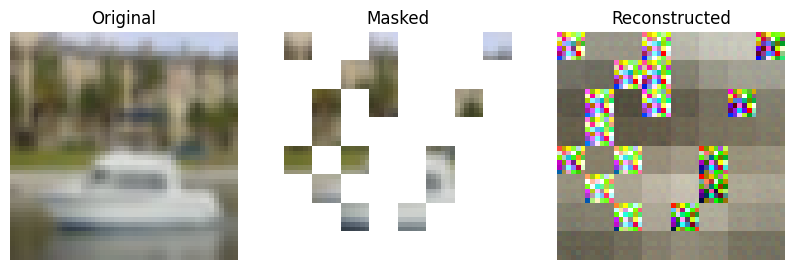

Epoch [46/100] Train Loss: 0.02488933


Epoch [46/100] Validation Loss: 0.02486306


Epoch [47/100] Train Loss: 0.02476879


Epoch [47/100] Validation Loss: 0.02461462


Epoch [48/100] Train Loss: 0.02467713


Epoch [48/100] Validation Loss: 0.02461235


Epoch [49/100] Train Loss: 0.02457287


Epoch [49/100] Validation Loss: 0.02452735


Epoch [50/100] Train Loss: 0.02440218


Epoch [50/100] Validation Loss: 0.02448015


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9140482..2.675484].


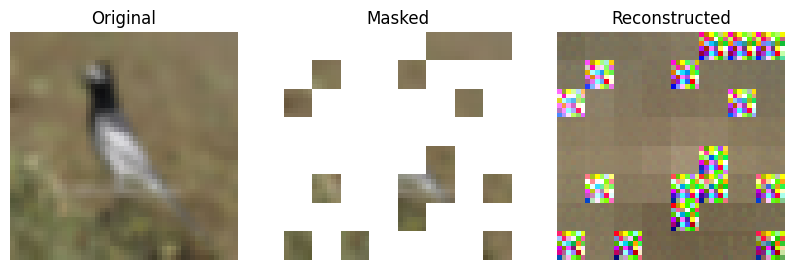

Epoch [51/100] Train Loss: 0.02433024


Epoch [51/100] Validation Loss: 0.02427648


Epoch [52/100] Train Loss: 0.02420706


Epoch [52/100] Validation Loss: 0.02418716


Epoch [53/100] Train Loss: 0.02404712


Epoch [53/100] Validation Loss: 0.02436380


Epoch [54/100] Train Loss: 0.02398835


Epoch [54/100] Validation Loss: 0.02397946


Epoch [55/100] Train Loss: 0.02382349


Epoch [55/100] Validation Loss: 0.02393104


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1729842..2.5949938].


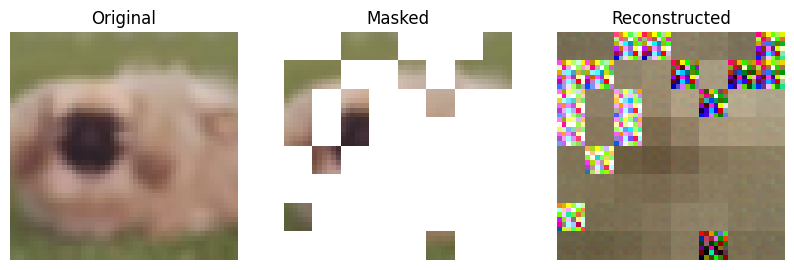

Epoch [56/100] Train Loss: 0.02375660


Epoch [56/100] Validation Loss: 0.02362320


Epoch [57/100] Train Loss: 0.02369862


Epoch [57/100] Validation Loss: 0.02355788


Epoch [58/100] Train Loss: 0.02358741


Epoch [58/100] Validation Loss: 0.02356192


Epoch [59/100] Train Loss: 0.02348400


Epoch [59/100] Validation Loss: 0.02389935


Epoch [60/100] Train Loss: 0.02338525


Epoch [60/100] Validation Loss: 0.02330177


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3793066..2.371108].


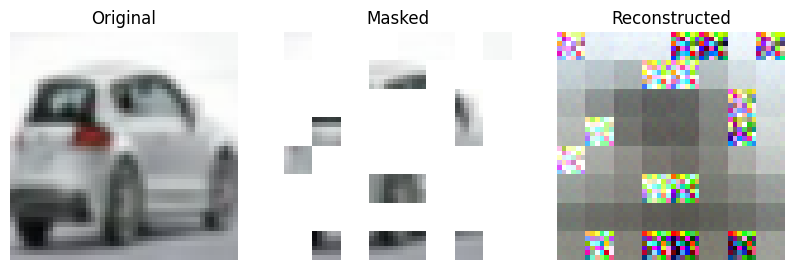

Epoch [61/100] Train Loss: 0.02329792


Epoch [61/100] Validation Loss: 0.02323786


Epoch [62/100] Train Loss: 0.02318762


Epoch [62/100] Validation Loss: 0.02319155


Epoch [63/100] Train Loss: 0.02309609


Epoch [63/100] Validation Loss: 0.02298278


Epoch [64/100] Train Loss: 0.02308366


Epoch [64/100] Validation Loss: 0.02297527


Epoch [65/100] Train Loss: 0.02291244


Epoch [65/100] Validation Loss: 0.02285623


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7312022..2.4325223].


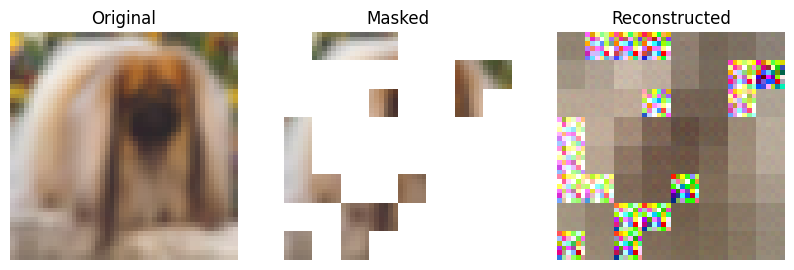

Epoch [66/100] Train Loss: 0.02285570


Epoch [66/100] Validation Loss: 0.02291452


Epoch [67/100] Train Loss: 0.02269744


Epoch [67/100] Validation Loss: 0.02282523


Epoch [68/100] Train Loss: 0.02256849


Epoch [68/100] Validation Loss: 0.02260489


Epoch [69/100] Train Loss: 0.02250991


Epoch [69/100] Validation Loss: 0.02244313


Epoch [70/100] Train Loss: 0.02234417


Epoch [70/100] Validation Loss: 0.02237172


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4372512..2.3737075].


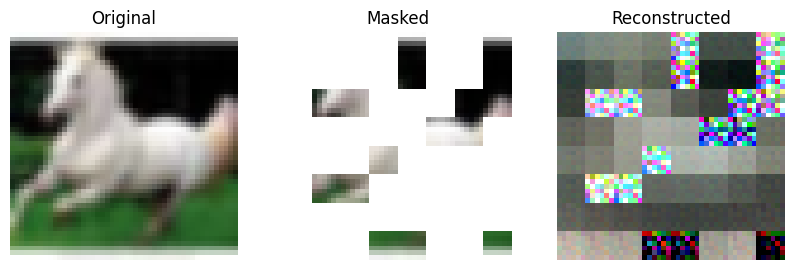

Epoch [71/100] Train Loss: 0.02223668


Epoch [71/100] Validation Loss: 0.02227980


Epoch [72/100] Train Loss: 0.02211048


Epoch [72/100] Validation Loss: 0.02220466


Epoch [73/100] Train Loss: 0.02202713


Epoch [73/100] Validation Loss: 0.02193291


Epoch [74/100] Train Loss: 0.02192618


Epoch [74/100] Validation Loss: 0.02183637


Epoch [75/100] Train Loss: 0.02183582


Epoch [75/100] Validation Loss: 0.02184431


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5616337..2.5546489].


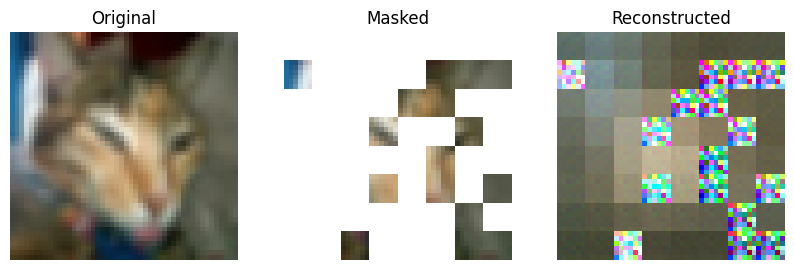

Epoch [76/100] Train Loss: 0.02180665


Epoch [76/100] Validation Loss: 0.02162763


Epoch [77/100] Train Loss: 0.02161120


Epoch [77/100] Validation Loss: 0.02150848


Epoch [78/100] Train Loss: 0.02154303


Epoch [78/100] Validation Loss: 0.02149565


Epoch [79/100] Train Loss: 0.02154201


Epoch [79/100] Validation Loss: 0.02134682


Epoch [80/100] Train Loss: 0.02140421


Epoch [80/100] Validation Loss: 0.02136049


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.87468225..2.4239652].


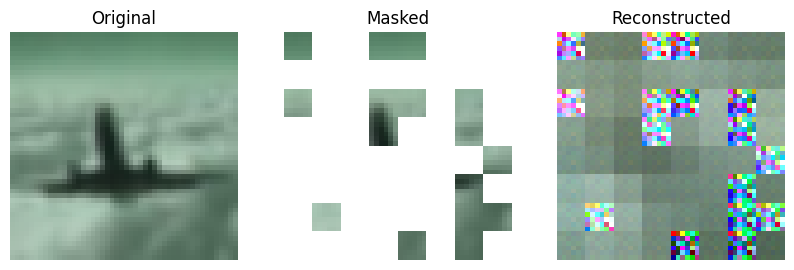

Epoch [81/100] Train Loss: 0.02138645


Epoch [81/100] Validation Loss: 0.02129906


Epoch [82/100] Train Loss: 0.02132703


Epoch [82/100] Validation Loss: 0.02118905


Epoch [83/100] Train Loss: 0.02121673


Epoch [83/100] Validation Loss: 0.02130234


Epoch [84/100] Train Loss: 0.02120214


Epoch [84/100] Validation Loss: 0.02104218


Epoch [85/100] Train Loss: 0.02109053


Epoch [85/100] Validation Loss: 0.02107845


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5207331..2.2960618].


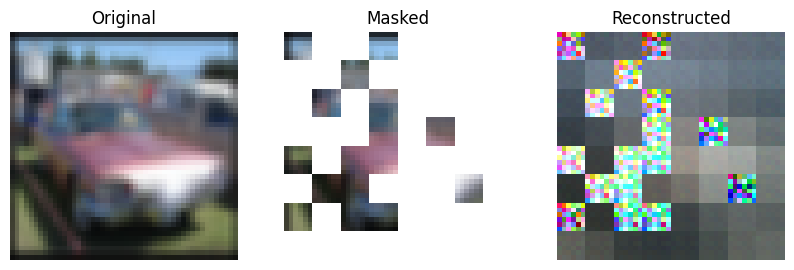

Epoch [86/100] Train Loss: 0.02106536


Epoch [86/100] Validation Loss: 0.02115823


Epoch [87/100] Train Loss: 0.02102988


Epoch [87/100] Validation Loss: 0.02093829


Epoch [88/100] Train Loss: 0.02087199


Epoch [88/100] Validation Loss: 0.02089852


Epoch [89/100] Train Loss: 0.02086242


Epoch [89/100] Validation Loss: 0.02081851


Epoch [90/100] Train Loss: 0.02076044


Epoch [90/100] Validation Loss: 0.02076295


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5394695..2.1882167].


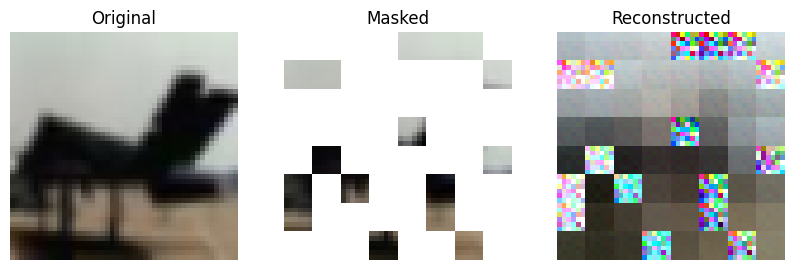

Epoch [91/100] Train Loss: 0.02073230


Epoch [91/100] Validation Loss: 0.02064062


Epoch [92/100] Train Loss: 0.02072761


Epoch [92/100] Validation Loss: 0.02069212


Epoch [93/100] Train Loss: 0.02066207


Epoch [93/100] Validation Loss: 0.02051266


Epoch [94/100] Train Loss: 0.02054451


Epoch [94/100] Validation Loss: 0.02075189


Epoch [95/100] Train Loss: 0.02060940


Epoch [95/100] Validation Loss: 0.02049758


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5914494..2.1901553].


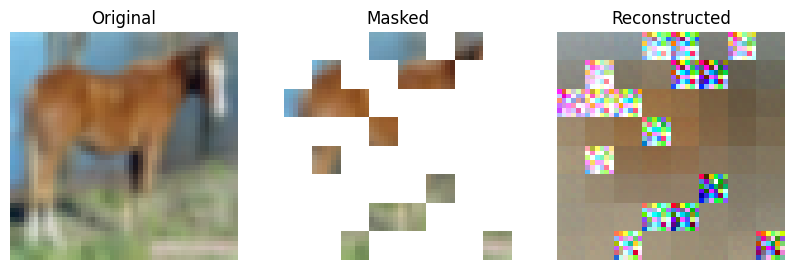

Epoch [96/100] Train Loss: 0.02043680


Epoch [96/100] Validation Loss: 0.02047149


Epoch [97/100] Train Loss: 0.02045330


Epoch [97/100] Validation Loss: 0.02047002


Epoch [98/100] Train Loss: 0.02037564


Epoch [98/100] Validation Loss: 0.02076928


Epoch [99/100] Train Loss: 0.02031628


Epoch [99/100] Validation Loss: 0.02032937


Epoch [100/100] Train Loss: 0.02026291


Epoch [100/100] Validation Loss: 0.02029305


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0846416..2.3047388].


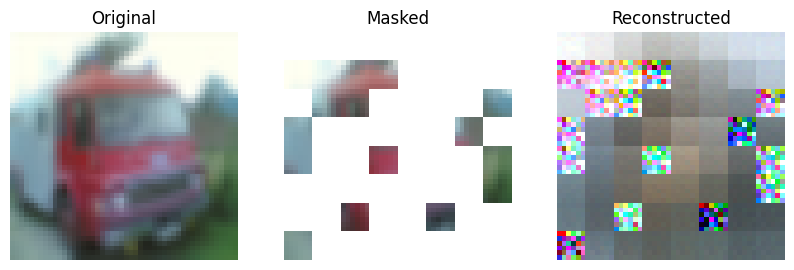

Training complete!


In [7]:
# Training loop
num_epochs = 100


for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    
    # Training loop with progress bar
    train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Train", leave=False)
    for images, _ in train_loop:  # unpack (images, labels)
        images = images.to(device)  # Move images to GPU
        
        optimizer.zero_grad()
        loss, _, _ = model(images)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        train_loop.set_postfix(loss=loss.item())
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_loss:.8f}")
    
    # Validation loop with progress bar
    model.eval()
    val_loss = 0.0
    val_loop = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Val", leave=False)
    with torch.no_grad():
        for images, _ in val_loop:  # unpack (images, labels)
            images = images.to(device)
            loss, _, _ = model(images)
            val_loss += loss.item()
            val_loop.set_postfix(loss=loss.item())
            
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Validation Loss: {avg_val_loss:.8f}")
    
    # plot each 5 epoch

    if (epoch+1) % 5 == 0:
        model.eval()
        with torch.no_grad():
            # select random batch
            images, _ = next(iter(val_loader))  # unpack (images, labels)
            images = images.to(device)

            _, pred, masks = model(images)

            # Split the images into patches
            patches = split_images(images, patch_size=6)

            masked_images = apply_mask_to_patches(images, patches, masks, patch_size=6)
            
            # unpatch the pred
            recon_images = model.unpatchify(pred)

            visualize_image(images, masked_images, recon_images)
            

        
print("Training complete!")


In [21]:
#save model

torch.save(model.state_dict(), "./checkpoints/mae_checkpoint.pth")

In [22]:
# load model

checkpoint = torch.load("./checkpoints/mae_checkpoint.pth")
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [23]:
# select a batch from validation set

images, _ = next(iter(val_loader))
images = images.to(device)

model.eval()

with torch.no_grad():
    _, recon_images, masks = model(images)


# Split the images into patches
patches = split_images(images, patch_size=6)


In [24]:
recon_images_unpatch = model.unpatchify(recon_images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8026726..2.1641603].


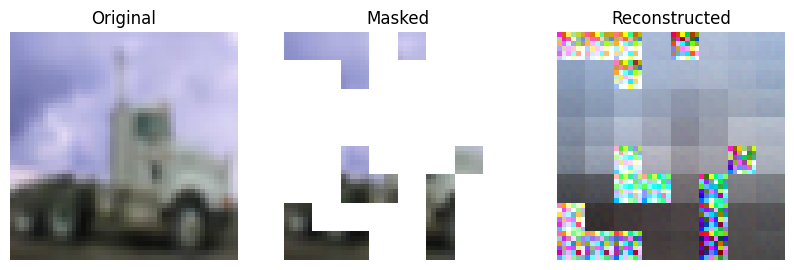

In [25]:
# Aplicar máscara às imagens
masked_images = apply_mask_to_patches(images, patches, masks, patch_size = 6)


# Visualizar
visualize_image(images, masked_images, recon_images_unpatch)
